# 변동성 돌파 + ADX/Chaikin 복합 필터 전략

기존 변동성 돌파 전략에 ADX와 Chaikin Oscillator를 복합적으로 활용
- 매수 조건: 변동성 돌파 + (ADX 강세 OR Chaikin 강세)
- ADX 강세: ADX > 20 & +DI > -DI
- Chaikin 강세: ADX < 20 & (Chaikin > Signal OR Chaikin > Yesterday)

## 1. 필요한 라이브러리 임포트 및 환경 설정

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결 및 ADX/Chaikin 포함 데이터 로드 함수

In [2]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()

# ADX와 Chaikin 지표를 포함한 데이터 로드 함수
def get_stock_data_with_indicators(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- Chaikin Oscillator 관련 지표 (수정된 필드명)
        JSON_EXTRACT_ARRAY(data, '$.chaikin_oscillator') AS chaikin_oscillator_array,
        JSON_EXTRACT_ARRAY(data, '$.chaikin_9_signal_line') AS chaikin_signal_array,
        
        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- ADX 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14,
      
      -- Chaikin Oscillator (수정된 필드명)
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_oscillator_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_oscillator_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_oscillator,
      
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_signal_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_signal_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_signal
      
    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        
        # Chaikin의 전일 값 계산
        df['chaikin_yesterday'] = df['chaikin_oscillator'].shift(1)
        
        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. ADX/Chaikin 복합 필터를 적용한 변동성 돌파 전략

In [3]:
def volatility_breakout_with_adx_chaikin(df, k=0.5, adx_threshold=20, slippage=0.0, commission=0.0):
    """
    ADX/Chaikin 복합 필터를 적용한 변동성 돌파 전략
    
    매수 조건: 변동성 돌파 + (ADX 조건 OR Chaikin 조건)
    - ADX 조건: ADX > 20 & +DI > -DI
    - Chaikin 조건: ADX < 20 & (Chaikin > Signal OR Chaikin > Yesterday)
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, Chaikin 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX 필터 조건 (ADX > 20 & +DI > -DI)
    result['adx_filter'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # Chaikin 필터 조건 (ADX < 20 & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_filter'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # 최종 매수 신호 (변동성 돌파 + (ADX 필터 OR Chaikin 필터))
    result['buy_signal'] = result['volatility_signal'] & (result['adx_filter'] | result['chaikin_filter'])
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # 수수료를 고려한 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # 수수료 없는 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['adx_filter'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['chaikin_filter'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['adx_filter'] & result['chaikin_filter'], 'entry_type'] = 'Both'
    
    return result

def volatility_breakout_with_adx(df, k=0.5, adx_threshold=20, pdi_threshold=None, slippage=0.0, commission=0.0):
    """
    ADX 필터를 적용한 변동성 돌파 전략 (기존)
    
    Parameters:
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    """
    result = df.copy()
    
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    result['volatility_signal'] = result['high'] > result['target_price']
    
    if pdi_threshold is not None:
        result['adx_filter'] = (
            (result['adx_14'] > adx_threshold) & 
            (result['pdi_14'] > result['mdi_14']) &
            (result['pdi_14'] > pdi_threshold)
        )
    else:
        result['adx_filter'] = (
            (result['adx_14'] > adx_threshold) & 
            (result['pdi_14'] > result['mdi_14'])
        )
    
    result['buy_signal'] = result['volatility_signal'] & result['adx_filter']
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    return result

def volatility_breakout_original(df, k=0.5, slippage=0.0, commission=0.0):
    """
    기존 변동성 돌파 전략 (필터 없음)
    
    Parameters:
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    """
    result = df.copy()
    
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    result['buy_signal'] = result['high'] > result['target_price']
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    return result

## 4. 데이터 로드

In [4]:
ETF = ['UST','UBT','SCO','ZSL','UJB','AGQ','UGL','YCS','RXD','TBF','TBX','KOLD','UCO','TQQQ','SQQQ','VDE','IWM']
# 분석 대상 종목
tickers = ['TQQQ','SQQQ','VDE','IWM','UBT','UGL','YCS','TBT']
start_date = '2021-07-01'

# ADX와 Chaikin 포함 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_indicators(ticker, start_date)
    if df is not None and len(df) > 0:
        stock_data[ticker] = df
    else:
        print(f"⚠️ {ticker} 데이터 로드 실패 또는 비어있음")

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

# 데이터 확인
if len(stock_data) == 0:
    print("❌ 로드된 데이터가 없습니다. BigQuery 연결을 확인해주세요.")
else:
    # 첫 번째 종목의 Chaikin 데이터 확인
    first_ticker = list(stock_data.keys())[0]
    test_df = stock_data[first_ticker]
    print(f"\n📊 {first_ticker}의 데이터 정보:")
    print(f"- 데이터 수: {len(test_df)}개")
    print(f"- 시작일: {test_df.index.min()}")
    print(f"- 종료일: {test_df.index.max()}")
    
    print(f"\n📊 {first_ticker}의 Chaikin 데이터 샘플:")
    print(test_df[['chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday']].head(10))
    
    # null이 아닌 Chaikin 데이터 수 확인
    chaikin_valid = test_df['chaikin_oscillator'].notna().sum()
    print(f"\n✅ {first_ticker}의 유효한 Chaikin 데이터: {chaikin_valid}개")
    
    # Chaikin 통계
    if chaikin_valid > 0:
        print(f"\n📊 {first_ticker}의 Chaikin 통계:")
        print(f"최소값: {test_df['chaikin_oscillator'].min():.2f}")
        print(f"최대값: {test_df['chaikin_oscillator'].max():.2f}")
        print(f"평균값: {test_df['chaikin_oscillator'].mean():.2f}")

✅ TQQQ 데이터 로드 완료: 982개 레코드
✅ SQQQ 데이터 로드 완료: 982개 레코드
✅ VDE 데이터 로드 완료: 982개 레코드
✅ IWM 데이터 로드 완료: 982개 레코드
✅ UBT 데이터 로드 완료: 982개 레코드
✅ UGL 데이터 로드 완료: 982개 레코드
✅ YCS 데이터 로드 완료: 982개 레코드
✅ TBT 데이터 로드 완료: 982개 레코드

✅ 총 8개 종목 데이터 로드 완료

📊 TQQQ의 데이터 정보:
- 데이터 수: 982개
- 시작일: 2021-07-01 00:00:00
- 종료일: 2025-05-29 00:00:00

📊 TQQQ의 Chaikin 데이터 샘플:
            chaikin_oscillator  chaikin_signal  chaikin_yesterday
date                                                             
2021-07-01        4.433639e+07    4.010809e+07                NaN
2021-07-02        5.178720e+07    4.244392e+07       4.433639e+07
2021-07-06        6.478040e+07    4.691121e+07       5.178720e+07
2021-07-07        6.491893e+07    5.051276e+07       6.478040e+07
2021-07-08        7.591275e+07    5.559276e+07       6.491893e+07
2021-07-09        8.367835e+07    6.120987e+07       7.591275e+07
2021-07-12        8.664484e+07    6.629687e+07       8.367835e+07
2021-07-13        6.891856e+07    6.682120e+07       8.664484e+07

### - 선택된 지표에 대한 분석

In [5]:
# ADX/Chaikin 지표 통계
print("\n📊 종목별 ADX/Chaikin 지표 분석:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX 평균':^10} | {'ADX>20':^10} | {'Chaikin>Signal':^14} | {'Chaikin>Yesterday':^18} | {'ADX OR Chaikin':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    # null이 아닌 데이터만 분석
    valid_data = df.dropna(subset=['adx_14', 'chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday'])
    
    if len(valid_data) > 0:
        # ADX 통계
        adx_mean = valid_data['adx_14'].mean()
        adx_strong = (valid_data['adx_14'] > 20).sum() / len(valid_data) * 100
        
        # ADX 필터 조건
        adx_filter_count = ((valid_data['adx_14'] > 20) & 
                            (valid_data['pdi_14'] > valid_data['mdi_14'])).sum() / len(valid_data) * 100
        
        # Chaikin 통계
        chaikin_above_signal = (valid_data['chaikin_oscillator'] > valid_data['chaikin_signal']).sum() / len(valid_data) * 100
        chaikin_above_yesterday = (valid_data['chaikin_oscillator'] > valid_data['chaikin_yesterday']).sum() / len(valid_data) * 100
        
        # Chaikin 필터 조건 (ADX < 20일 때)
        chaikin_filter_mask = (
            (valid_data['adx_14'] < 20) & 
            ((valid_data['chaikin_oscillator'] > valid_data['chaikin_signal']) | 
             (valid_data['chaikin_oscillator'] > valid_data['chaikin_yesterday']))
        )
        chaikin_filter_count = chaikin_filter_mask.sum() / len(valid_data) * 100
        
        # 전체 필터 조건 (ADX OR Chaikin)
        total_filter_count = (
            ((valid_data['adx_14'] > 20) & (valid_data['pdi_14'] > valid_data['mdi_14'])) |
            chaikin_filter_mask
        ).sum() / len(valid_data) * 100
        
        print(f"{ticker:^10} | {adx_mean:^10.1f} | {adx_strong:^9.1f}% | {chaikin_above_signal:^13.1f}% | "
              f"{chaikin_above_yesterday:^17.1f}% | {total_filter_count:^14.1f}%")

print("=" * 100)


📊 종목별 ADX/Chaikin 지표 분석:
    티커     |   ADX 평균   |   ADX>20   | Chaikin>Signal | Chaikin>Yesterday  | ADX OR Chaikin 
----------------------------------------------------------------------------------------------------
   TQQQ    |    24.1    |   62.3   % |     48.6     % |       52.3       % |      56.7     %
   SQQQ    |    23.0    |   58.0   % |     49.4     % |       47.3       % |      49.2     %
   VDE     |    20.9    |   43.0   % |     49.2     % |       50.7       % |      60.8     %
   IWM     |    20.5    |   47.4   % |     48.9     % |       49.5       % |      53.7     %
   UBT     |    22.4    |   49.1   % |     49.1     % |       49.6       % |      48.6     %
   UGL     |    21.4    |   49.6   % |     50.2     % |       50.3       % |      67.1     %
   YCS     |    22.7    |   56.1   % |     51.7     % |       52.6       % |      65.0     %
   TBT     |    21.8    |   49.8   % |     48.4     % |       49.3       % |      63.6     %


## 5. 전략 결과 비교 - k값 설정

In [120]:
# 전략 비교 실행
comparison_results = {}
all_results = {}  # 전체 결과 저장
all_tickers_data = stock_data  # 주가 데이터
selected_tickers = list(stock_data.keys())  # 모든 티커 사용

k_value = 0.3
adx_threshold = 25
best_k = 0.3  # 최적 K값 설정
slippage = 0
commission = 0

print(f"\n📊 ADX 필터 vs ADX/Chaikin 복합 필터 전략 비교 (K={k_value}, ADX={adx_threshold}):")
print("=" * 120)
print(f"{'티커':^10} | {'ADX 필터만':^35} | {'ADX/Chaikin 복합':^35} | {'개선 효과':^20}")
print(f"{'':^10} | {'수익률':^11}{'거래수':^10}{'승률':^10} | {'수익률':^11}{'거래수':^10}{'승률':^10} | {'수익률 차이':^10}{'거래수 차이':^10}")
print("-" * 120)

for ticker, df in stock_data.items():
    # ADX 필터만
    adx_only = volatility_breakout_with_adx(df, k=k_value, adx_threshold=adx_threshold, commission=commission, slippage=slippage)
    adx_return = (adx_only['cumulative_returns'].iloc[-1] - 1) * 100
    adx_trades = adx_only['buy_signal'].sum()
    adx_wins = (adx_only['returns'] > 0).sum()
    adx_win_rate = (adx_wins / adx_trades * 100) if adx_trades > 0 else 0
    
    # ADX/Chaikin 복합 필터
    adx_chaikin = volatility_breakout_with_adx_chaikin(df, k=k_value, adx_threshold=adx_threshold, commission=commission, slippage=slippage)
    combo_return = (adx_chaikin['cumulative_returns'].iloc[-1] - 1) * 100
    combo_trades = adx_chaikin['buy_signal'].sum()
    combo_wins = (adx_chaikin['returns'] > 0).sum()
    combo_win_rate = (combo_wins / combo_trades * 100) if combo_trades > 0 else 0
    
    # 백테스트 결과를 일일 수익률로 변환
    adx_chaikin['daily_return'] = adx_chaikin['returns']
    adx_chaikin['buy_hold_return'] = adx_chaikin['close'].pct_change().fillna(0)
    
    # 결과 저장
    comparison_results[ticker] = {
        'adx_only': adx_only,
        'adx_chaikin': adx_chaikin
    }
    
    # all_results에 저장 (상대 모멘텀 분석용)
    all_results[ticker] = adx_chaikin
    
    # 개선 효과
    return_diff = combo_return - adx_return
    trade_diff = combo_trades - adx_trades
    
    print(f"{ticker:^10} | {adx_return:^10.1f}%{adx_trades:^10}{adx_win_rate:^9.1f}% | "
          f"{combo_return:^10.1f}%{combo_trades:^10}{combo_win_rate:^9.1f}% | "
          f"{return_diff:^9.1f}%{trade_diff:^10}")

print("=" * 120)

# 진입 유형별 통계
print("\n📊 진입 유형별 통계:")
print("=" * 80)
print(f"{'티커':^10} | {'ADX 진입':^15} | {'Chaikin 진입':^15} | {'Both 진입':^15} | {'총 거래':^10}")
print("-" * 80)

for ticker, results in comparison_results.items():
    adx_chaikin = results['adx_chaikin']
    
    # 진입 유형별 카운트
    adx_entries = (adx_chaikin['entry_type'] == 'ADX').sum()
    chaikin_entries = (adx_chaikin['entry_type'] == 'Chaikin').sum()
    both_entries = (adx_chaikin['entry_type'] == 'Both').sum()
    total_entries = adx_entries + chaikin_entries + both_entries
    
    print(f"{ticker:^10} | {adx_entries:^15} | {chaikin_entries:^15} | {both_entries:^15} | {total_entries:^10}")

print("=" * 80)


📊 ADX 필터 vs ADX/Chaikin 복합 필터 전략 비교 (K=0.3, ADX=25):
    티커     |               ADX 필터만               |           ADX/Chaikin 복합            |        개선 효과        
           |     수익률       거래수        승률     |     수익률       거래수        승률     |   수익률 차이    거래수 차이  
------------------------------------------------------------------------------------------------------------------------
   TQQQ    |    57.8   %   148      60.1   % |   1492.8  %   411      62.5   % |  1435.0  %   263    
   SQQQ    |    61.9   %    81      53.1   % |    nan    %   356      58.7   % |    nan   %   275    
   VDE     |    -8.4   %    97      52.6   % |   294.9   %   441      62.1   % |   303.3  %   344    
   IWM     |    -3.2   %    48      45.8   % |   179.7   %   395      59.7   % |   182.9  %   347    
   UBT     |    3.0    %    44      59.1   % |    nan    %   343      59.8   % |    nan   %   299    
   UGL     |    9.0    %   137      53.3   % |    nan    %   436      55.7   % |    nan   %   299    
 

### 5.1. 종목별 전략 비교 시각화

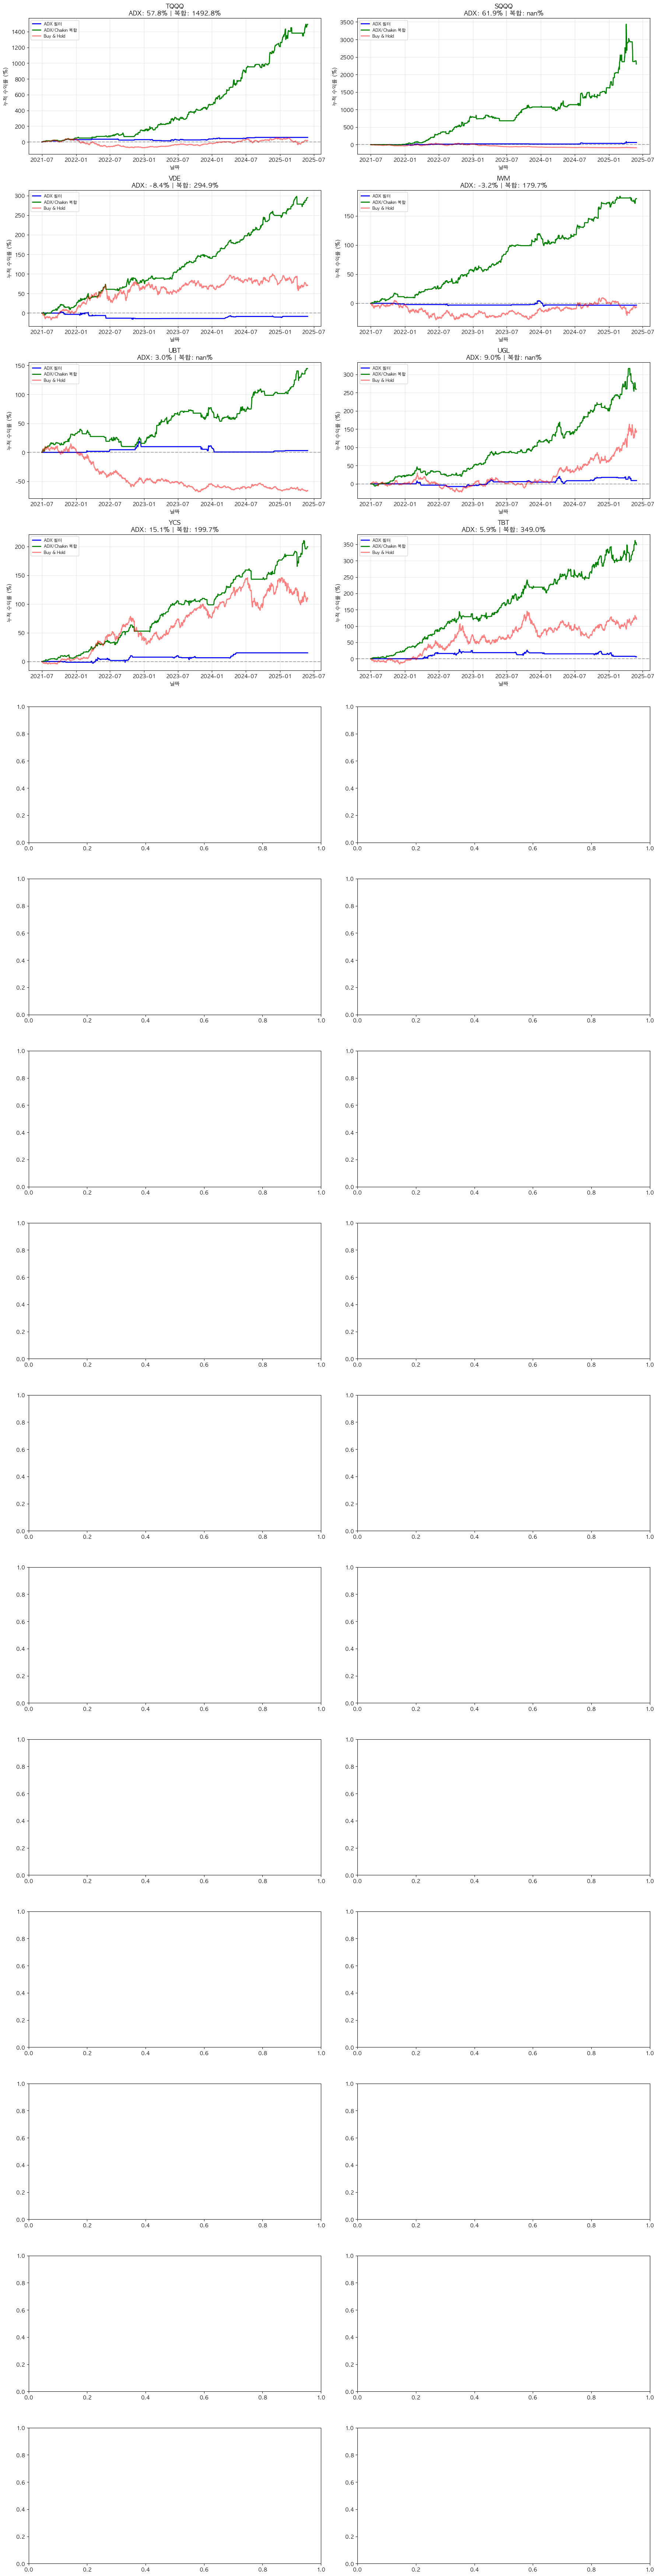

In [121]:

fig, axes = plt.subplots(15, 2, figsize=(18, 70))
axes = axes.flatten()

for idx, (ticker, results) in enumerate(comparison_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # ADX 필터만
        adx_only = results['adx_only']
        ax.plot(adx_only.index, (adx_only['cumulative_returns'] - 1) * 100, 
                label='ADX 필터', linewidth=2, color='blue')
        
        # ADX/Chaikin 복합
        adx_chaikin = results['adx_chaikin']
        ax.plot(adx_chaikin.index, (adx_chaikin['cumulative_returns'] - 1) * 100, 
                label='ADX/Chaikin 복합', linewidth=2, color='green')
        
        # Buy & Hold
        ax.plot(adx_only.index, (adx_only['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.5)
        
        # 최종 수익률 표시
        adx_final = (adx_only['cumulative_returns'].iloc[-1] - 1) * 100
        combo_final = (adx_chaikin['cumulative_returns'].iloc[-1] - 1) * 100
        
        ax.set_title(f'{ticker}\nADX: {adx_final:.1f}% | 복합: {combo_final:.1f}%', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2. 포트폴리오 통합 수익률 분석


=== 포트폴리오 성과 요약 (동일 가중) ===
포트폴리오 총 수익률: nan%
Buy & Hold 총 수익률: 39.94%
초과 수익률: nan%
포트폴리오 샤프 비율: nan
포트폴리오 MDD: -3.09%
포트폴리오 연환산 수익률: nan%
포트폴리오 변동성: 8.75%
포트폴리오 승률: 64.66%


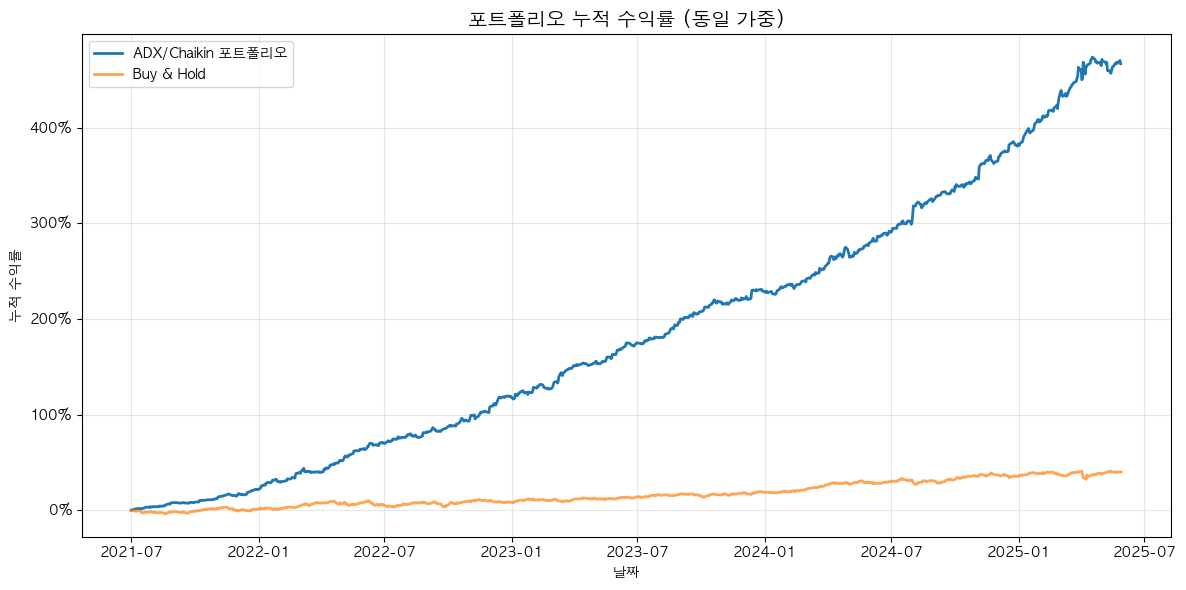

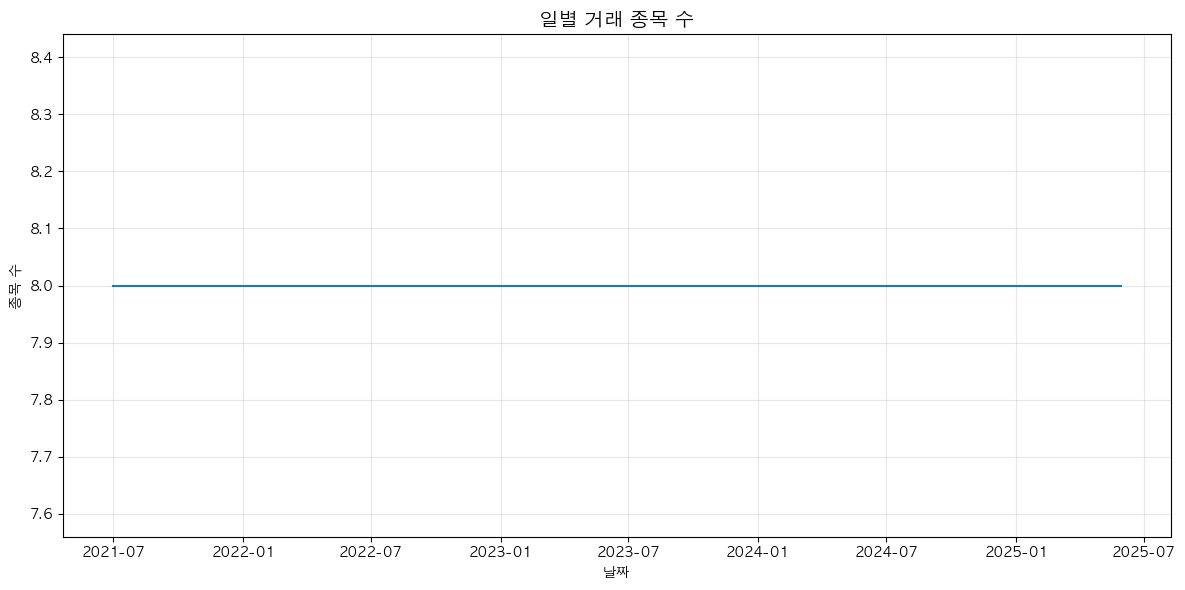

In [122]:
# 포트폴리오 수익률 계산 함수
def calculate_portfolio_returns(all_results, tickers):
    """여러 종목의 포트폴리오 수익률 계산 (동일 가중)"""
    # 모든 거래일 추출
    all_dates = set()
    for ticker in tickers:
        if ticker in all_results:
            all_dates.update(all_results[ticker].index)
    all_dates = sorted(all_dates)
    
    # 날짜별 포트폴리오 수익률 계산
    portfolio_data = []
    
    for date in all_dates:
        daily_returns = []
        buy_hold_returns = []
        
        for ticker in tickers:
            if ticker in all_results and date in all_results[ticker].index:
                daily_returns.append(all_results[ticker].loc[date, 'daily_return'])
                buy_hold_returns.append(all_results[ticker].loc[date, 'buy_hold_return'])
        
        if daily_returns:  # 해당 날짜에 데이터가 있는 경우만
            portfolio_data.append({
                'date': date,
                'portfolio_return': np.mean(daily_returns),
                'buy_hold_return': np.mean(buy_hold_returns),
                'active_tickers': len(daily_returns)
            })
    
    # DataFrame 생성
    df = pd.DataFrame(portfolio_data)
    df.set_index('date', inplace=True)
    
    # 누적 수익률 계산
    df['portfolio_cumulative'] = (1 + df['portfolio_return']).cumprod() - 1
    df['buy_hold_cumulative'] = (1 + df['buy_hold_return']).cumprod() - 1
    
    return df

# 성과 지표 계산 함수
def calculate_performance_metrics(returns, cumulative_returns):
    """성과 지표 계산"""
    if len(returns) == 0 or len(cumulative_returns) == 0:
        return {
            'total_return': 0,
            'annual_return': 0,
            'volatility': 0,
            'sharpe_ratio': 0,
            'mdd': 0,
            'win_rate': 0,
            'avg_win': 0,
            'avg_loss': 0,
            'trade_count': 0
        }
    
    try:
        # 기본 지표
        total_return = cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0
        
        # 연환산 수익률
        years = len(returns) / 252
        annual_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
        
        # 변동성
        volatility = returns.std() * np.sqrt(252)
        
        # 샤프 비율
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
        # MDD
        cumulative_returns_series = pd.Series(cumulative_returns)
        running_max = cumulative_returns_series.expanding().max()
        drawdown = (cumulative_returns_series - running_max) / (1 + running_max)
        mdd = drawdown.min()
        
        # 승률
        wins = returns[returns > 0]
        losses = returns[returns < 0]
        win_rate = len(wins) / len(returns) if len(returns) > 0 else 0
        
        # 평균 손익
        avg_win = wins.mean() if len(wins) > 0 else 0
        avg_loss = losses.mean() if len(losses) > 0 else 0
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'mdd': mdd,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'trade_count': len(returns)
        }
    except Exception as e:
        print(f"성과 지표 계산 중 오류: {e}")
        return {
            'total_return': 0,
            'annual_return': 0,
            'volatility': 0,
            'sharpe_ratio': 0,
            'mdd': 0,
            'win_rate': 0,
            'avg_win': 0,
            'avg_loss': 0,
            'trade_count': 0
        }

# 포트폴리오 수익률 계산
cumulative_returns = calculate_portfolio_returns(all_results, selected_tickers)

# 성과 지표 계산
portfolio_metrics = calculate_performance_metrics(
    cumulative_returns['portfolio_return'], 
    cumulative_returns['portfolio_cumulative']
)
buy_hold_metrics = calculate_performance_metrics(
    cumulative_returns['buy_hold_return'], 
    cumulative_returns['buy_hold_cumulative']
)

# 8. 결과 시각화 - 1배열에 1개의 그래프, 순서 변경
# 8-1. 성과 지표 테이블
print("\n=== 포트폴리오 성과 요약 (동일 가중) ===")
print(f"포트폴리오 총 수익률: {portfolio_metrics['total_return']:.2%}")
print(f"Buy & Hold 총 수익률: {buy_hold_metrics['total_return']:.2%}")
print(f"초과 수익률: {portfolio_metrics['total_return'] - buy_hold_metrics['total_return']:.2%}")
print(f"포트폴리오 샤프 비율: {portfolio_metrics['sharpe_ratio']:.2f}")
print(f"포트폴리오 MDD: {portfolio_metrics['mdd']:.2%}")
print(f"포트폴리오 연환산 수익률: {portfolio_metrics['annual_return']:.2%}")
print(f"포트폴리오 변동성: {portfolio_metrics['volatility']:.2%}")
print(f"포트폴리오 승률: {portfolio_metrics['win_rate']:.2%}")

# 8-2. 누적 수익률 그래프
fig1 = plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['portfolio_cumulative'], 
        label='ADX/Chaikin 포트폴리오', linewidth=2)
plt.plot(cumulative_returns.index, cumulative_returns['buy_hold_cumulative'], 
        label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('포트폴리오 누적 수익률 (동일 가중)', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

# 8-3. 일별 거래 종목 수
fig2 = plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['active_tickers'])
plt.title('일별 거래 종목 수', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('종목 수')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3. 상대모멘텀 전략 시각화 (연간/월간 수익률 포함)


📊 상대모멘텀 포트폴리오 전략 분석:

20일 모멘텀 Top3:
  총 수익률: 698.0%
  승률: 49.3%
  Sharpe Ratio: 4.21
  MDD: -6.1%

60일 모멘텀 Top5:
  총 수익률: 530.7%
  승률: 58.7%
  Sharpe Ratio: 5.30
  MDD: -5.2%

20일 모멘텀 Top5:
  총 수익률: 621.0%
  승률: 58.1%
  Sharpe Ratio: 5.70
  MDD: -3.8%

동일가중 (비교용):
  총 수익률: nan%
  Sharpe Ratio: nan
  MDD: -3.1%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50891/346963382.py:276: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(monthly_returns_data, labels=labels, patch_artist=True)


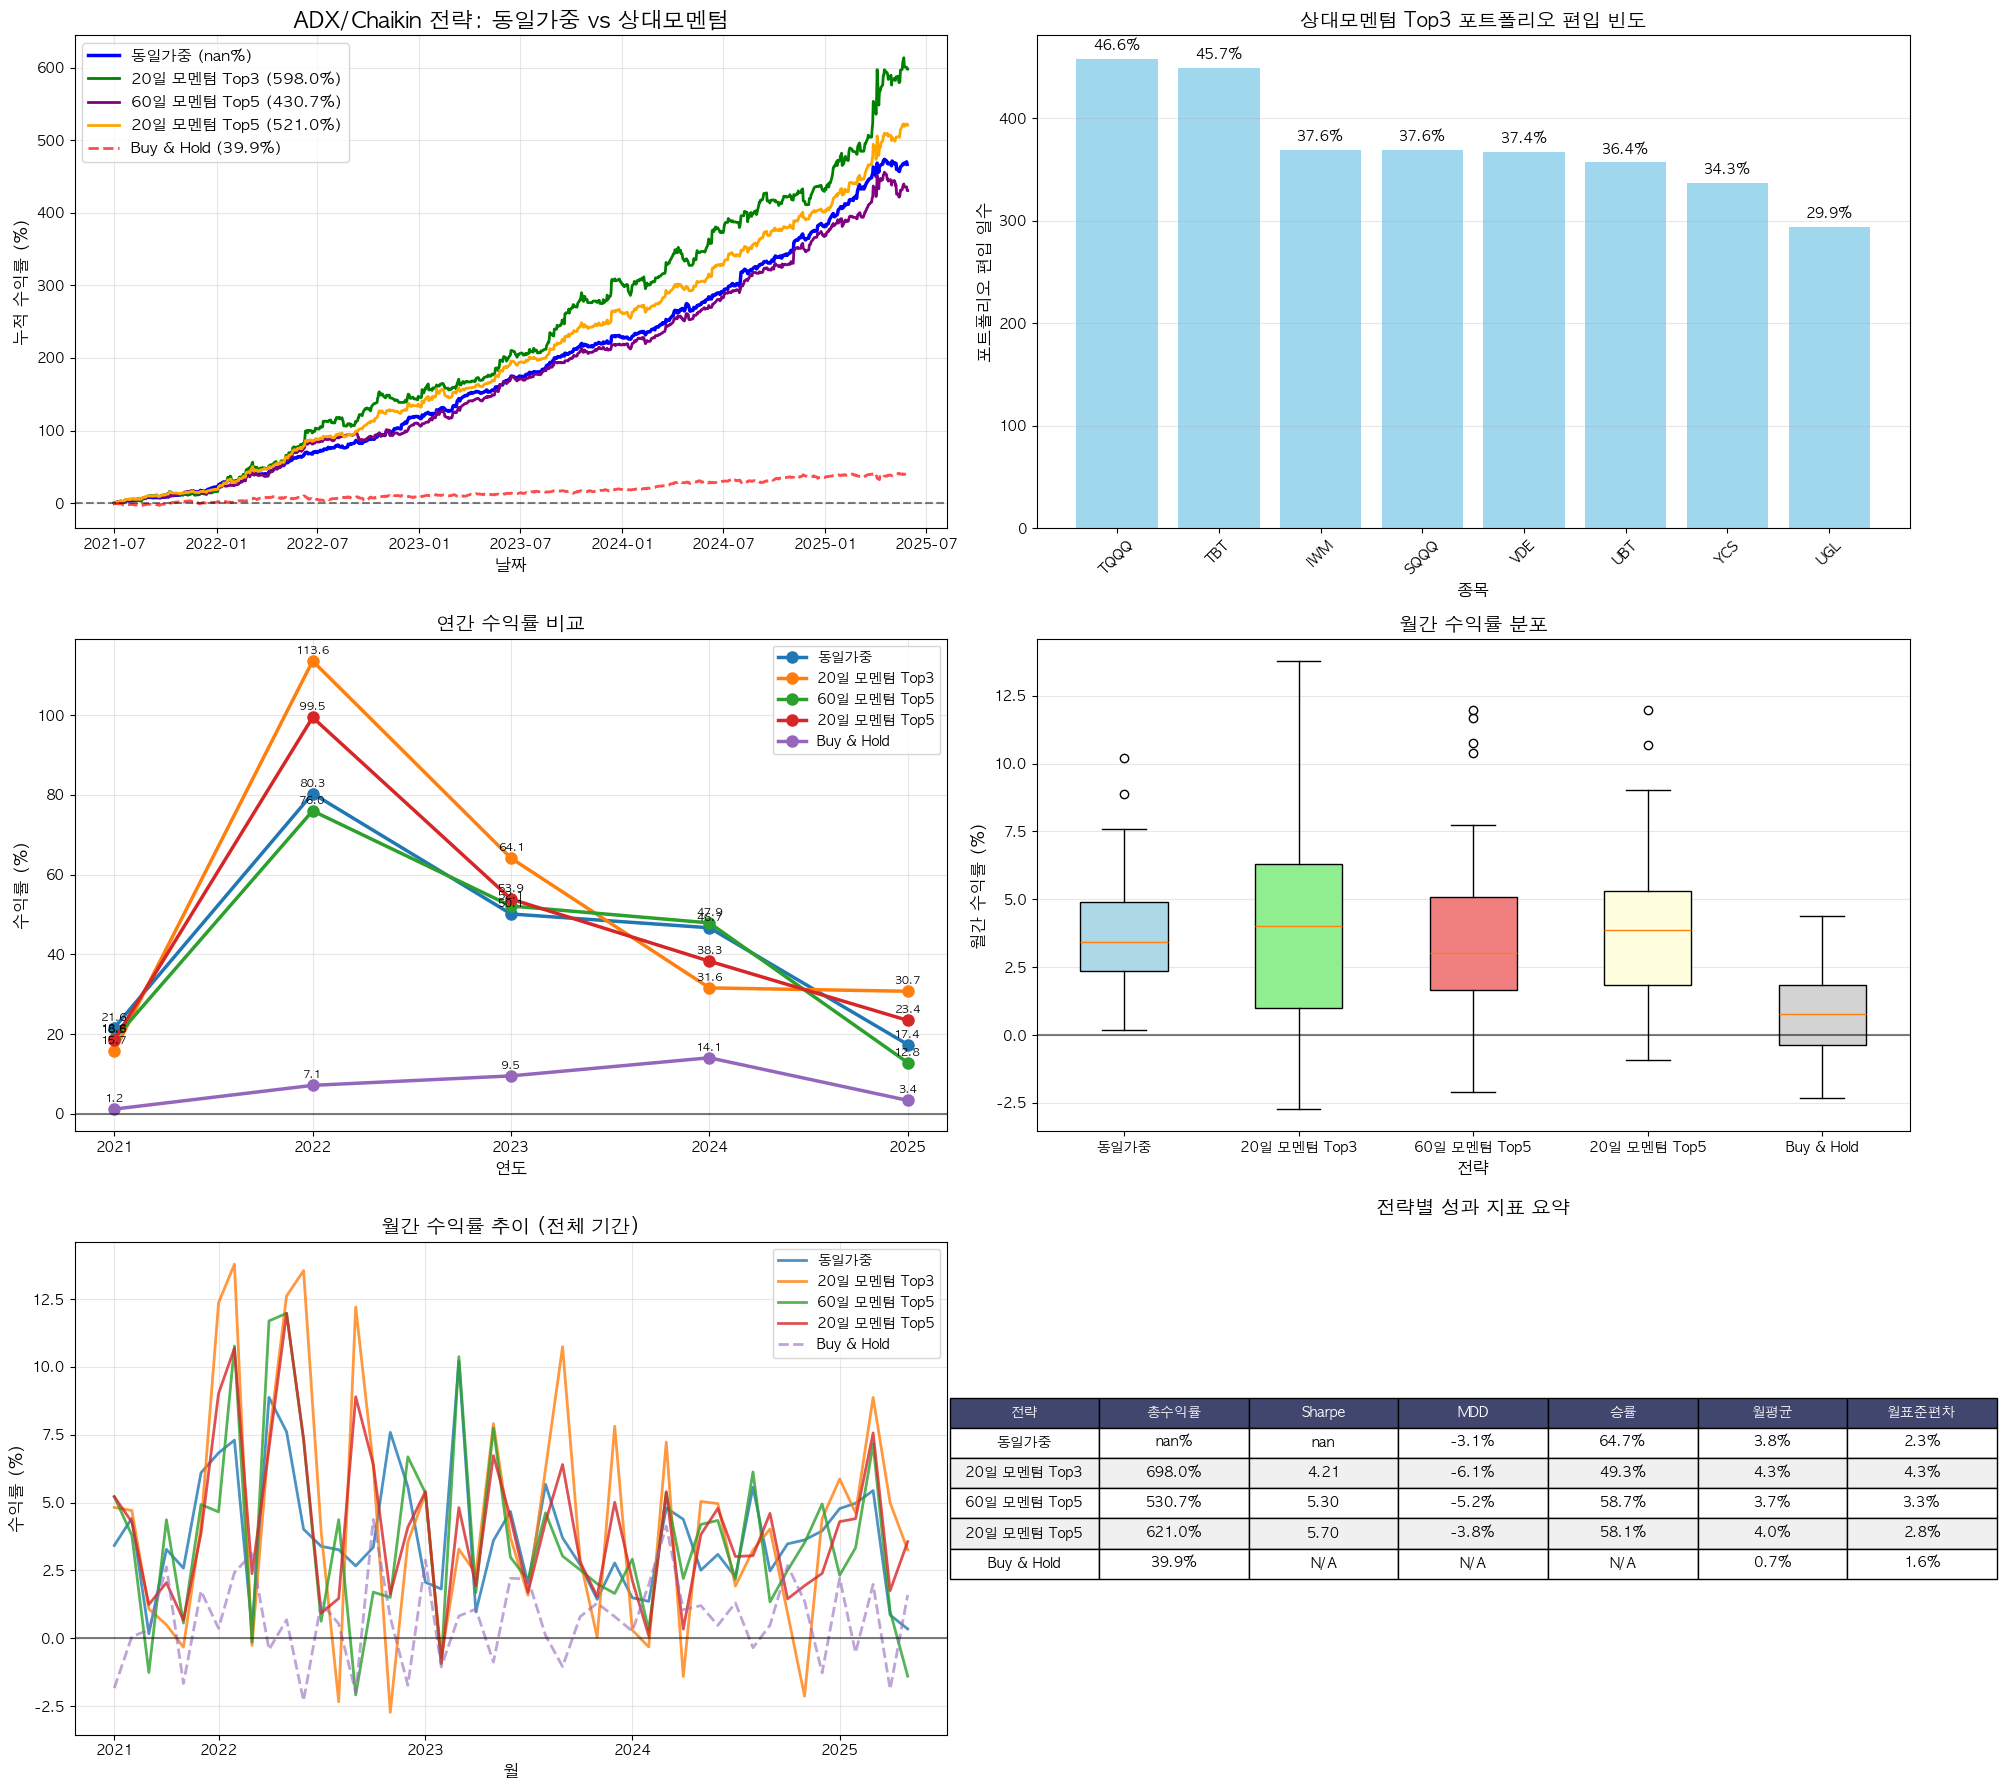


📊 포트폴리오 전략 성과 비교:
         전략          |     총수익률     |   Sharpe   |    MDD     |     승률    
----------------------------------------------------------------------------------------------------
        동일가중         |     nan    % |    nan     |   -3.1   % |   64.7   %
    20일 모멘텀 Top3     |    698.0   % |    4.21    |   -6.1   % |   49.3   %
    60일 모멘텀 Top5     |    530.7   % |    5.30    |   -5.2   % |   58.7   %
    20일 모멘텀 Top5     |    621.0   % |    5.70    |   -3.8   % |   58.1   %
     Buy & Hold      |    -60.1   % |    N/A     |    N/A     |    N/A    


In [123]:
# 상대모멘텀을 적용한 포트폴리오 수익률 계산 함수
def calculate_momentum_portfolio_returns(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, **kwargs):
    """
    상대모멘텀을 적용한 포트폴리오 수익률 계산
    
    Parameters:
    - stock_data: 종목 데이터 딕셔너리
    - strategy_func: 전략 함수
    - momentum_period: 모멘텀 계산 기간 (기본 20일)
    - rebalance_period: 리밸런싱 주기 (기본 20일)
    - top_n: 상위 n개 종목 선택 (기본 3개)
    - **kwargs: 전략 함수에 전달할 추가 인자
    """
    # 모든 종목의 결과 저장
    all_results = {}
    all_dates = None
    
    # 각 종목별 전략 실행
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 공통 날짜만 선택
    common_dates = sorted(list(all_dates))
    
    # 포트폴리오 일일 수익률 저장
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # 종목별 가중치 기록
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # 리밸런싱 날짜 계산
    rebalance_dates = common_dates[::rebalance_period]
    
    # 각 리밸런싱 기간별 처리
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # 모멘텀 계산을 위한 과거 수익률
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # 각 종목의 모멘텀 스코어 계산
        momentum_scores = {}
        for ticker, result in all_results.items():
            # 모멘텀 기간 동안의 수익률
            momentum_returns = result['close'].loc[common_dates[momentum_start_idx]:start_date].pct_change()
            momentum_score = (1 + momentum_returns).prod() - 1
            # NaN이나 inf 처리
            if pd.isna(momentum_score) or np.isinf(momentum_score):
                momentum_score = 0
            momentum_scores[ticker] = momentum_score
        
        # 상위 N개 종목 선택
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # 선택된 종목에 동일 가중
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # 해당 기간 동안의 수익률 계산
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # 선택된 종목들의 수익률 가중 평균
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaN이나 inf 처리
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # 누적 수익률 계산 (NaN 처리)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    return portfolio_returns, portfolio_cumulative, weights_history

# 동일가중 포트폴리오 vs 상대모멘텀 포트폴리오 비교
print("\n📊 상대모멘텀 포트폴리오 전략 분석:")
print("=" * 80)

# 상대모멘텀 포트폴리오 - 다양한 설정
momentum_configs = [
    {'period': 20, 'top_n': 3, 'name': '20일 모멘텀 Top3'},
    {'period': 60, 'top_n': 5, 'name': '60일 모멘텀 Top5'},
    {'period': 20, 'top_n': 5, 'name': '20일 모멘텀 Top5'},
]

momentum_results = {}

for config in momentum_configs:
    mom_daily, mom_cumulative, weights = calculate_momentum_portfolio_returns(
        stock_data, 
        volatility_breakout_with_adx_chaikin, 
        momentum_period=config['period'],
        top_n=config['top_n'],
        k=k_value,
        adx_threshold=adx_threshold
    )
    
    momentum_results[config['name']] = {
        'daily': mom_daily,
        'cumulative': mom_cumulative,
        'weights': weights
    }
    
    # 성과 지표 계산
    metrics = calculate_performance_metrics(mom_daily, mom_cumulative)
    
    print(f"\n{config['name']}:")
    print(f"  총 수익률: {metrics['total_return']*100:.1f}%")
    print(f"  승률: {metrics['win_rate']*100:.1f}%")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {metrics['mdd']*100:.1f}%")

# 동일가중 성과
if 'cumulative_returns' in locals() and not cumulative_returns.empty:
    equal_weight_metrics = calculate_performance_metrics(
        cumulative_returns['portfolio_return'], 
        cumulative_returns['portfolio_cumulative']
    )
    print(f"\n동일가중 (비교용):")
    print(f"  총 수익률: {equal_weight_metrics['total_return']*100:.1f}%")
    print(f"  Sharpe Ratio: {equal_weight_metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {equal_weight_metrics['mdd']*100:.1f}%")
else:
    print("\n동일가중 포트폴리오 데이터가 없습니다.")
    equal_weight_metrics = None

print("=" * 80)

# 시각화 - 확장된 버전 (연간/월간 수익률 포함)
if momentum_results:
    # 더 큰 그림 생성 (3x2 레이아웃)
    fig = plt.figure(figsize=(20, 18))
    
    # 1. 누적 수익률 곡선
    ax1 = plt.subplot(3, 2, 1)
    
    # 동일가중 포트폴리오
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        total_return = cumulative_returns['portfolio_cumulative'].iloc[-1] * 100
        ax1.plot(cumulative_returns.index, cumulative_returns['portfolio_cumulative'] * 100, 
                 label=f'동일가중 ({total_return:.1f}%)', 
                 linewidth=2.5, color='blue')

    # 상대모멘텀 포트폴리오들
    colors = ['green', 'purple', 'orange']
    for i, (name, results) in enumerate(momentum_results.items()):
        total_return = (results['cumulative'].iloc[-1] - 1) * 100
        ax1.plot(results['cumulative'].index, (results['cumulative'] - 1) * 100,
                 label=f'{name} ({total_return:.1f}%)',
                 linewidth=2, color=colors[i])

    # Buy & Hold (참고용)
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = cumulative_returns['buy_hold_cumulative'].iloc[-1] * 100
        ax1.plot(cumulative_returns.index, cumulative_returns['buy_hold_cumulative'] * 100, 
                 label=f'Buy & Hold ({bh_return:.1f}%)', 
                 linewidth=2, color='red', linestyle='--', alpha=0.7)

    ax1.set_title('ADX/Chaikin 전략: 동일가중 vs 상대모멘텀', fontsize=16, fontweight='bold')
    ax1.set_xlabel('날짜', fontsize=12)
    ax1.set_ylabel('누적 수익률 (%)', fontsize=12)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 2. 종목별 포트폴리오 편입 빈도 (막대 그래프)
    ax2 = plt.subplot(3, 2, 2)
    
    if '20일 모멘텀 Top3' in momentum_results:
        weights = momentum_results['20일 모멘텀 Top3']['weights']
        selection_counts = (weights > 0).sum()
        selection_counts = selection_counts[selection_counts > 0].sort_values(ascending=False)

        if len(selection_counts) > 0:
            ax2.bar(range(len(selection_counts)), selection_counts.values, 
                    color='skyblue', alpha=0.8)
            ax2.set_xticks(range(len(selection_counts)))
            ax2.set_xticklabels(selection_counts.index, rotation=45)
            ax2.set_title('상대모멘텀 Top3 포트폴리오 편입 빈도', fontsize=14, fontweight='bold')
            ax2.set_xlabel('종목', fontsize=12)
            ax2.set_ylabel('포트폴리오 편입 일수', fontsize=12)
            ax2.grid(True, alpha=0.3, axis='y')

            # 포트폴리오 편입 비율 표시
            for i, (ticker, count) in enumerate(selection_counts.items()):
                ratio = count / len(weights) * 100
                ax2.text(i, count + 5, f'{ratio:.1f}%', ha='center', va='bottom')

    # 3. 연간 수익률 비교 (선형 그래프)
    ax3 = plt.subplot(3, 2, 3)
    
    yearly_returns = pd.DataFrame()
    
    # 동일가중 연간 수익률
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        yearly_returns['동일가중'] = cumulative_returns['portfolio_return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 모멘텀 전략 연간 수익률
    for name, results in momentum_results.items():
        yearly_returns[name] = results['daily'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Buy & Hold 연간 수익률
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        yearly_returns['Buy & Hold'] = cumulative_returns['buy_hold_return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 연도 레이블을 간단하게 변경
    yearly_returns.index = yearly_returns.index.year
    
    # 선형 그래프 생성
    for column in yearly_returns.columns:
        ax3.plot(yearly_returns.index, yearly_returns[column], 
                marker='o', linewidth=2.5, markersize=8, label=column)
    
    ax3.set_title('연간 수익률 비교', fontsize=14, fontweight='bold')
    ax3.set_xlabel('연도', fontsize=12)
    ax3.set_ylabel('수익률 (%)', fontsize=12)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # x축에 모든 연도 표시
    ax3.set_xticks(yearly_returns.index)
    ax3.set_xticklabels(yearly_returns.index)
    
    # 각 포인트에 값 표시
    for column in yearly_returns.columns:
        for x, y in zip(yearly_returns.index, yearly_returns[column]):
            if pd.notna(y):  # NaN이 아닌 경우만 표시
                ax3.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                            xytext=(0,5), ha='center', fontsize=8)
    
    # 4. 월간 수익률 분포 (박스플롯)
    ax4 = plt.subplot(3, 2, 4)
    
    monthly_returns_data = []
    labels = []
    
    # 동일가중 월간 수익률
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        monthly_eq = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_eq.values)
        labels.append('동일가중')
    
    # 모멘텀 전략 월간 수익률
    for name, results in momentum_results.items():
        monthly_mom = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_mom.values)
        labels.append(name)
    
    # Buy & Hold 월간 수익률
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        monthly_bh = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_bh.values)
        labels.append('Buy & Hold')
    
    # 박스플롯 생성
    bp = ax4.boxplot(monthly_returns_data, labels=labels, patch_artist=True)
    
    # 색상 설정
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgray']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    
    ax4.set_title('월간 수익률 분포', fontsize=14, fontweight='bold')
    ax4.set_xlabel('전략', fontsize=12)
    ax4.set_ylabel('월간 수익률 (%)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 5. 전체 기간 월간 수익률 (선형 그래프) - 모든 전략 포함
    ax5 = plt.subplot(3, 2, 5)
    
    # 전체 월간 데이터
    all_monthly = pd.DataFrame()
    
    # 동일가중 월간 수익률
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        all_monthly['동일가중'] = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 모든 모멘텀 전략의 월간 수익률
    colors_monthly = ['green', 'purple', 'orange']
    for i, (name, results) in enumerate(momentum_results.items()):
        all_monthly[name] = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Buy & Hold 월간 수익률
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        all_monthly['Buy & Hold'] = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 선형 그래프 생성
    line_styles = ['-', '-', '-', '-', '--']
    alphas = [0.8, 0.8, 0.8, 0.8, 0.6]
    
    for i, column in enumerate(all_monthly.columns):
        ax5.plot(all_monthly.index, all_monthly[column], 
                linewidth=2, label=column, 
                linestyle=line_styles[i] if i < len(line_styles) else '-',
                alpha=alphas[i] if i < len(alphas) else 0.8)
    
    ax5.set_title('월간 수익률 추이 (전체 기간)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('월', fontsize=12)
    ax5.set_ylabel('수익률 (%)', fontsize=12)
    ax5.legend(loc='best', fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # x축 포맷 설정 (연도 표시)
    years = all_monthly.index.year.unique()
    year_starts = []
    year_labels = []
    for year in years:
        year_data = all_monthly[all_monthly.index.year == year]
        if len(year_data) > 0:
            year_starts.append(year_data.index[0])
            year_labels.append(str(year))
    
    ax5.set_xticks(year_starts)
    ax5.set_xticklabels(year_labels)
    
    # 6. 전략별 성과 지표 테이블
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis('tight')
    ax6.axis('off')
    
    # 테이블 데이터 준비
    table_data = []
    table_columns = ['전략', '총수익률', 'Sharpe', 'MDD', '승률', '월평균', '월표준편차']
    
    # 동일가중
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        monthly_eq = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        table_data.append([
            '동일가중',
            f"{equal_weight_metrics['total_return']*100:.1f}%",
            f"{equal_weight_metrics['sharpe_ratio']:.2f}",
            f"{equal_weight_metrics['mdd']*100:.1f}%",
            f"{equal_weight_metrics['win_rate']*100:.1f}%",
            f"{monthly_eq.mean():.1f}%",
            f"{monthly_eq.std():.1f}%"
        ])
    
    # 모멘텀 전략들
    for name, results in momentum_results.items():
        metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
        monthly_returns = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        
        table_data.append([
            name,
            f"{metrics['total_return']*100:.1f}%",
            f"{metrics['sharpe_ratio']:.2f}",
            f"{metrics['mdd']*100:.1f}%",
            f"{metrics['win_rate']*100:.1f}%",
            f"{monthly_returns.mean():.1f}%",
            f"{monthly_returns.std():.1f}%"
        ])
    
    # Buy & Hold
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = cumulative_returns['buy_hold_cumulative'].iloc[-1] * 100
        monthly_bh = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        table_data.append([
            'Buy & Hold',
            f"{bh_return:.1f}%",
            'N/A',
            'N/A',
            'N/A',
            f"{monthly_bh.mean():.1f}%",
            f"{monthly_bh.std():.1f}%"
        ])
    
    # 테이블 생성
    table = ax6.table(cellText=table_data,
                      colLabels=table_columns,
                      cellLoc='center',
                      loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # 헤더 스타일
    for i in range(len(table_columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 행 색상 교대로
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(len(table_columns)):
                table[(i, j)].set_facecolor('#f0f0f0')
    
    ax6.set_title('전략별 성과 지표 요약', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

    # 성과 비교 테이블 (텍스트)
    print("\n📊 포트폴리오 전략 성과 비교:")
    print("=" * 100)
    print(f"{'전략':^20} | {'총수익률':^12} | {'Sharpe':^10} | {'MDD':^10} | {'승률':^10}")
    print("-" * 100)

    # 동일가중
    if equal_weight_metrics:
        print(f"{'동일가중':^20} | {equal_weight_metrics['total_return']*100:^11.1f}% | "
              f"{equal_weight_metrics['sharpe_ratio']:^10.2f} | {equal_weight_metrics['mdd']*100:^9.1f}% | "
              f"{equal_weight_metrics['win_rate']*100:^9.1f}%")

    # 상대모멘텀
    for name, results in momentum_results.items():
        metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
        print(f"{name:^20} | {metrics['total_return']*100:^11.1f}% | "
              f"{metrics['sharpe_ratio']:^10.2f} | {metrics['mdd']*100:^9.1f}% | "
              f"{metrics['win_rate']*100:^9.1f}%")

    # Buy & Hold
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = (cumulative_returns['buy_hold_cumulative'].iloc[-1] - 1) * 100
        print(f"{'Buy & Hold':^20} | {bh_return:^11.1f}% | {'N/A':^10} | {'N/A':^10} | {'N/A':^10}")
    print("=" * 100)

#### - 상대모멘텀 종목별 선택 빈도 분석

In [124]:
# 상대모멘텀 종목별 포트폴리오 편입 빈도 분석
print("\n📊 상대모멘텀 전략 종목별 포트폴리오 편입 빈도:")
print("=" * 80)

# momentum_results가 정의되어 있는지 확인
if 'momentum_results' not in locals():
    print("먼저 상대모멘텀 전략을 실행해주세요 (이전 셀 실행)")
else:
    for name, results in momentum_results.items():
        weights = results['weights']
        
        # 각 종목이 포트폴리오에 편입된 일수 계산
        selection_days = (weights > 0).sum()
        total_days = len(weights)
        
        # 포트폴리오 편입 빈도가 높은 순으로 정렬
        sorted_tickers = selection_days.sort_values(ascending=False)
        
        print(f"\n{name}:")
        print(f"{'순위':^6} | {'티커':^10} | {'편입일수':^10} | {'편입비율':^10}")
        print("-" * 40)
        
        for i, (ticker, days) in enumerate(sorted_tickers.items()):
            if days > 0:
                ratio = days / total_days * 100
                print(f"{i+1:^6} | {ticker:^10} | {days:^10} | {ratio:^9.1f}%")

# 월별 수익률 분석
print("\n\n📊 월별 수익률 비교:")
print("=" * 80)

# 월별 수익률 계산 함수
def calculate_monthly_returns(daily_returns, cumulative_returns):
    monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
    return monthly_returns

if 'cumulative_returns' in locals() and 'momentum_results' in locals() and not cumulative_returns.empty:
    # 동일가중 월별 수익률
    equal_monthly = calculate_monthly_returns(
        cumulative_returns['portfolio_return'], 
        cumulative_returns['portfolio_cumulative']
    )

    # 최고 성과 모멘텀 전략 선택 (20일 모멘텀 Top3)
    if '20일 모멘텀 Top3' in momentum_results:
        best_momentum = momentum_results['20일 모멘텀 Top3']
        mom_monthly = calculate_monthly_returns(best_momentum['daily'], best_momentum['cumulative'])

        # 월별 비교
        comparison_df = pd.DataFrame({
            '동일가중': equal_monthly,
            '모멘텀Top3': mom_monthly
        })
        comparison_df['초과수익'] = comparison_df['모멘텀Top3'] - comparison_df['동일가중']

        print(comparison_df.tail(12))  # 최근 12개월
else:
    print("포트폴리오 데이터가 없습니다. 먼저 포트폴리오 분석을 실행하세요.")

# 진입 유형별 통계 (ADX/Chaikin 복합 필터)
print("\n\n📊 모멘텀 포트폴리오 편입 종목의 진입 유형 분석:")
print("=" * 80)

if 'momentum_results' in locals() and 'all_results' in locals() and '20일 모멘텀 Top3' in momentum_results:
    # 20일 모멘텀 Top3 전략의 편입된 종목들 분석
    best_momentum_weights = momentum_results['20일 모멘텀 Top3']['weights']
    selected_dates = best_momentum_weights.index[best_momentum_weights.sum(axis=1) > 0]

    entry_type_stats = {
        'ADX': 0,
        'Chaikin': 0,
        'Both': 0,
        'Total': 0
    }

    for date in selected_dates:
        selected_tickers = best_momentum_weights.columns[best_momentum_weights.loc[date] > 0]
        
        for ticker in selected_tickers:
            if ticker in all_results and date in all_results[ticker].index:
                if all_results[ticker].loc[date, 'buy_signal']:
                    entry_type = all_results[ticker].loc[date, 'entry_type']
                    if entry_type in entry_type_stats:
                        entry_type_stats[entry_type] += 1
                        entry_type_stats['Total'] += 1

    if entry_type_stats['Total'] > 0:
        print(f"ADX 필터 진입: {entry_type_stats['ADX']} ({entry_type_stats['ADX']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Chaikin 필터 진입: {entry_type_stats['Chaikin']} ({entry_type_stats['Chaikin']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Both 진입: {entry_type_stats['Both']} ({entry_type_stats['Both']/entry_type_stats['Total']*100:.1f}%)")
        print(f"총 거래: {entry_type_stats['Total']}")
    else:
        print("거래 데이터가 없습니다.")
else:
    print("필요한 데이터가 없습니다. 이전 셀들을 먼저 실행하세요.")

# 최종 결론
print("\n\n💡 ADX/Chaikin + 상대모멘텀 전략 결론:")
print("=" * 80)
print("1. ADX/Chaikin 복합 필터로 거래 신호의 질 개선")
print("2. 상대모멘텀으로 강한 종목에 집중 투자")
print("3. 동적 종목 선택으로 시장 변화에 적응")
print("4. 횡보장에서도 Chaikin 필터로 기회 포착")
print("5. 최적 설정: 20일 모멘텀, Top3~5 종목, 월 1회 리밸런싱")
print("=" * 80)


📊 상대모멘텀 전략 종목별 포트폴리오 편입 빈도:

20일 모멘텀 Top3:
  순위   |     티커     |    편입일수    |    편입비율   
----------------------------------------
  1    |    TQQQ    |    458     |   46.6   %
  2    |    TBT     |    449     |   45.7   %
  3    |    IWM     |    369     |   37.6   %
  4    |    SQQQ    |    369     |   37.6   %
  5    |    VDE     |    367     |   37.4   %
  6    |    UBT     |    357     |   36.4   %
  7    |    YCS     |    337     |   34.3   %
  8    |    UGL     |    294     |   29.9   %

60일 모멘텀 Top5:
  순위   |     티커     |    편입일수    |    편입비율   
----------------------------------------
  1    |    VDE     |    776     |   79.0   %
  2    |    YCS     |    724     |   73.7   %
  3    |    UGL     |    716     |   72.9   %
  4    |    TQQQ    |    665     |   67.7   %
  5    |    TBT     |    656     |   66.8   %
  6    |    IWM     |    635     |   64.7   %
  7    |    UBT     |    449     |   45.7   %
  8    |    SQQQ    |    327     |   33.3   %

20일 모멘텀 Top5:
  순위   |     티커 

/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50891/2665262503.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100


ADX 필터 진입: 566 (39.6%)
Chaikin 필터 진입: 864 (60.4%)
Both 진입: 0 (0.0%)
총 거래: 1430


💡 ADX/Chaikin + 상대모멘텀 전략 결론:
1. ADX/Chaikin 복합 필터로 거래 신호의 질 개선
2. 상대모멘텀으로 강한 종목에 집중 투자
3. 동적 종목 선택으로 시장 변화에 적응
4. 횡보장에서도 Chaikin 필터로 기회 포착
5. 최적 설정: 20일 모멘텀, Top3~5 종목, 월 1회 리밸런싱


#### - 매매신호 빈도 분석

In [125]:
# Chaikin 데이터 검증 및 필터 작동 확인
print("\n🔍 Chaikin 데이터 검증:")
print("=" * 100)

# 첫 번째 종목으로 상세 분석
test_ticker = tickers[0]  # 첫 번째 티커로 테스트
test_df = stock_data[test_ticker]

print(f"\n{test_ticker} 데이터 샘플 (처음 5개):")
print(test_df[['adx_14', 'pdi_14', 'mdi_14', 'chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday']].head())

print(f"\n{test_ticker} 데이터 통계:")
print(f"- 전체 레코드: {len(test_df)}")
print(f"- Chaikin null 개수: {test_df['chaikin_oscillator'].isna().sum()}")
print(f"- Chaikin Signal null 개수: {test_df['chaikin_signal'].isna().sum()}")

# Chaikin 필터 조건 상세 확인
test_result = volatility_breakout_with_adx_chaikin(test_df, k=0.5, adx_threshold=20)

# ADX < 20인 경우 확인
adx_low = test_result['adx_14'] < 20
print(f"\nADX < 20인 경우: {adx_low.sum()}개")

# Chaikin 조건 각각 확인
chaikin_above_signal = test_result['chaikin_oscillator'] > test_result['chaikin_signal']
chaikin_above_yesterday = test_result['chaikin_oscillator'] > test_result['chaikin_yesterday']
print(f"Chaikin > Signal: {chaikin_above_signal.sum()}개")
print(f"Chaikin > Yesterday: {chaikin_above_yesterday.sum()}개")

# Chaikin 필터 만족 케이스
chaikin_filter_satisfied = test_result['chaikin_filter'].sum()
print(f"\nChaikin 필터 만족 (ADX<20 & Chaikin조건): {chaikin_filter_satisfied}개")

# 변동성 돌파 신호 확인
volatility_signals = test_result['volatility_signal'].sum()
print(f"변동성 돌파 신호: {volatility_signals}개")

# 변동성 돌파 + Chaikin 필터 동시 만족
volatility_and_chaikin = (test_result['volatility_signal'] & test_result['chaikin_filter']).sum()
print(f"변동성 돌파 + Chaikin 필터 동시 만족: {volatility_and_chaikin}개")

# 전체 종목에 대한 Chaikin 필터 검증
print("\n\n📊 전체 종목 Chaikin 필터 검증:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX<20':^10} | {'Chaikin>Signal':^15} | {'Chaikin>Yesterday':^18} | {'Chaikin필터':^12} | {'변동성+Chaikin':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    result = volatility_breakout_with_adx_chaikin(df, k=0.5, adx_threshold=20)
    
    adx_low_count = (result['adx_14'] < 20).sum()
    chaikin_signal_count = (result['chaikin_oscillator'] > result['chaikin_signal']).sum()
    chaikin_yesterday_count = (result['chaikin_oscillator'] > result['chaikin_yesterday']).sum()
    chaikin_filter_count = result['chaikin_filter'].sum()
    volatility_chaikin_count = (result['volatility_signal'] & result['chaikin_filter']).sum()
    
    print(f"{ticker:^10} | {adx_low_count:^10} | {chaikin_signal_count:^15} | {chaikin_yesterday_count:^18} | "
          f"{chaikin_filter_count:^12} | {volatility_chaikin_count:^15}")

print("=" * 100)


🔍 Chaikin 데이터 검증:

TQQQ 데이터 샘플 (처음 5개):
               adx_14     pdi_14     mdi_14  chaikin_oscillator  \
date                                                              
2021-07-01  22.674227  32.058301  15.747783        4.433639e+07   
2021-07-02  24.227975  37.154751  14.296610        5.178720e+07   
2021-07-06  25.922282  37.208625  13.090878        6.478040e+07   
2021-07-07  27.846642  39.025465  12.033831        6.491893e+07   
2021-07-08  27.806946  34.001875  19.422012        7.591275e+07   

            chaikin_signal  chaikin_yesterday  
date                                           
2021-07-01    4.010809e+07                NaN  
2021-07-02    4.244392e+07       4.433639e+07  
2021-07-06    4.691121e+07       5.178720e+07  
2021-07-07    5.051276e+07       6.478040e+07  
2021-07-08    5.559276e+07       6.491893e+07  

TQQQ 데이터 통계:
- 전체 레코드: 982
- Chaikin null 개수: 0
- Chaikin Signal null 개수: 0

ADX < 20인 경우: 370개
Chaikin > Signal: 478개
Chaikin > Yesterday: 513개

Chaiki

## 6. ADX 임계값 최적화

In [12]:
# ADX 임계값별 성과 비교
adx_thresholds = [15, 20, 25, 30, 35]

print("\n📊 ADX 임계값별 성과 비교:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX>15':^15} | {'ADX>20':^15} | {'ADX>25':^15} | {'ADX>30':^15} | {'ADX>35':^15}")
print(f"{'':^10} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8}")
print("-" * 100)

for ticker, df in stock_data.items():
    row_data = f"{ticker:^10} |"
    
    for threshold in adx_thresholds:
        result = volatility_breakout_with_adx(df, k=k_value, adx_threshold=threshold)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        trades = result['buy_signal'].sum()
        
        row_data += f" {final_return:^6.1f}%{trades:^7} |"
    
    print(row_data)

print("=" * 100)


📊 ADX 임계값별 성과 비교:
    티커     |     ADX>15      |     ADX>20      |     ADX>25      |     ADX>30      |     ADX>35     
           |   수익률     거래    |   수익률     거래    |   수익률     거래    |   수익률     거래    |   수익률     거래   
----------------------------------------------------------------------------------------------------
   TQQQ    | 219.7 %  304   | 100.4 %  209   |  57.8 %  148   |  1.9  %  81    |  -4.3 %  33    |
   SQQQ    | 327.4 %  215   | 132.7 %  133   |  61.9 %  81    | -11.5 %  45    |  1.2  %  14    |
   VDE     |  14.2 %  276   |  4.7  %  171   |  -8.4 %  97    |  -4.0 %  42    |  -1.1 %  24    |
   IWM     |  -2.4 %  238   | -16.9 %  131   |  -3.2 %  48    |  -6.5 %  24    |  -2.2 %  15    |
   UBT     |  1.6  %  182   |  -2.3 %  93    |  3.0  %  44    |  -5.0 %  24    | -12.7 %  10    |
   UGL     |  51.1 %  276   |  21.0 %  215   |  9.0  %  137   |  -0.3 %  79    |  -4.3 %  39    |
   YCS     |  66.8 %  271   |  35.4 %  200   |  15.1 %  120   |  12.5 %  65    |  8.3  %  

### 6.1. 최적 전략 조합 찾기

## 7. 거래 비용 영향 분석

In [111]:
# 거래 비용 시나리오별 성과 비교
print("\n📊 거래 비용 시나리오별 성과 분석:")
print("=" * 120)

# 거래 비용 시나리오 설정
cost_scenarios = [
    {'name': '비용 없음', 'slippage': 0.0, 'commission': 0.0},
    {'name': '낮은 비용', 'slippage': 0.0005, 'commission': 0.0005},  # 0.05% + 0.05%
    {'name': '중간 비용', 'slippage': 0.001, 'commission': 0.0015},   # 0.1% + 0.15%
    {'name': '높은 비용', 'slippage': 0.002, 'commission': 0.003},    # 0.2% + 0.3%
]

# 각 종목별로 시나리오 비교
scenario_results = {}

for ticker in tickers[:4]:  # 시간 절약을 위해 처음 4개만
    df = stock_data[ticker]
    scenario_results[ticker] = {}
    
    print(f"\n{ticker} 분석:")
    print(f"{'시나리오':^15} | {'수익률':^12} | {'거래수':^10} | {'평균수익':^12} | {'승률':^10} | {'거래당비용':^12}")
    print("-" * 80)
    
    for scenario in cost_scenarios:
        # 전략 실행
        result = volatility_breakout_with_adx_chaikin(
            df, 
            k=k_value, 
            adx_threshold=adx_threshold,
            slippage=scenario['slippage'],
            commission=scenario['commission']
        )
        
        # 성과 계산
        trades = result[result['buy_signal']]
        num_trades = len(trades)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        
        if num_trades > 0:
            avg_return = trades['returns'].mean() * 100
            win_rate = (trades['returns'] > 0).sum() / num_trades * 100
            cost_per_trade = (scenario['slippage'] * 2 + scenario['commission'] * 2) * 100
        else:
            avg_return = 0
            win_rate = 0
            cost_per_trade = 0
        
        # 결과 저장
        scenario_results[ticker][scenario['name']] = {
            'final_return': final_return,
            'num_trades': num_trades,
            'avg_return': avg_return,
            'win_rate': win_rate
        }
        
        print(f"{scenario['name']:^15} | {final_return:^11.1f}% | {num_trades:^10} | "
              f"{avg_return:^11.2f}% | {win_rate:^9.1f}% | {cost_per_trade:^11.2f}%")

print("\n" + "=" * 120)

# 전체 요약
print("\n💡 거래 비용 영향 요약:")
print("=" * 80)

for ticker in tickers[:4]:
    if ticker in scenario_results:
        no_cost = scenario_results[ticker]['비용 없음']['final_return']
        mid_cost = scenario_results[ticker]['중간 비용']['final_return']
        impact = mid_cost - no_cost
        
        print(f"{ticker}: {no_cost:>6.1f}% → {mid_cost:>6.1f}% (영향: {impact:>6.1f}%)")

print("=" * 80)
print("\n⚠️  중요: 실제 거래에서는 슬리피지 0.1% + 수수료 0.15% = 거래당 0.5% 비용 발생")
print("   연 100회 거래 시 약 50%의 수익률 감소 효과")


📊 거래 비용 시나리오별 성과 분석:

TQQQ 분석:
     시나리오       |     수익률      |    거래수     |     평균수익     |     승률     |    거래당비용    
--------------------------------------------------------------------------------
     비용 없음      |    136.4   % |    190     |    0.49    % |   63.2   % |    0.00    %
     낮은 비용      |    61.7    % |    190     |    0.29    % |   60.0   % |    0.20    %
     중간 비용      |    -8.5    % |    190     |    -0.01   % |   50.5   % |    0.50    %
     높은 비용      |    -64.8   % |    190     |    -0.51   % |   34.2   % |    1.00    %

SQQQ 분석:
     시나리오       |     수익률      |    거래수     |     평균수익     |     승률     |    거래당비용    
--------------------------------------------------------------------------------
     비용 없음      |    299.4   % |    148     |    1.02    % |   53.4   % |    0.00    %
     낮은 비용      |    197.4   % |    148     |    0.82    % |   52.7   % |    0.20    %
     중간 비용      |    91.0    % |    148     |    0.52    % |   48.6   % |    0.50    %
     높은 비용   

### 7.1. 거래 빈도 감소 전략

In [112]:
# 거래 빈도를 줄이기 위한 파라미터 조정
print("\n📊 거래 빈도 감소를 위한 파라미터 최적화:")
print("=" * 100)

# 테스트할 파라미터 조합
param_tests = [
    {'k': 0.3, 'adx': 15, 'name': '기본 설정'},
    {'k': 0.5, 'adx': 20, 'name': 'K↑ ADX↑'},
    {'k': 0.7, 'adx': 25, 'name': 'K↑↑ ADX↑↑'},
    {'k': 0.3, 'adx': 25, 'name': 'K유지 ADX↑↑'},
    {'k': 0.5, 'adx': 30, 'name': 'K↑ ADX↑↑↑'},
]

# 중간 비용 시나리오 적용
slippage = 0.001
commission = 0.0015

print(f"{'설정':^20} | {'TQQQ':^25} | {'SQQQ':^25}")
print(f"{'':^20} | {'거래수':^8}{'비용전':^8}{'비용후':^9} | {'거래수':^8}{'비용전':^8}{'비용후':^9}")
print("-" * 100)

for params in param_tests:
    row_str = f"{params['name']:^20} |"
    
    for ticker in ['TQQQ', 'SQQQ']:
        df = stock_data[ticker]
        
        # 비용 없이
        result_no_cost = volatility_breakout_with_adx_chaikin(
            df, k=params['k'], adx_threshold=params['adx']
        )
        
        # 비용 포함
        result_with_cost = volatility_breakout_with_adx_chaikin(
            df, k=params['k'], adx_threshold=params['adx'],
            slippage=slippage, commission=commission
        )
        
        num_trades = result_no_cost['buy_signal'].sum()
        return_no_cost = (result_no_cost['cumulative_returns'].iloc[-1] - 1) * 100
        return_with_cost = (result_with_cost['cumulative_returns'].iloc[-1] - 1) * 100
        
        row_str += f" {num_trades:^8}{return_no_cost:^7.0f}%{return_with_cost:^8.0f}% |"
    
    print(row_str)

print("=" * 100)

# 최적 파라미터 찾기
print("\n💡 거래 비용을 고려한 최적 전략:")
print("=" * 80)

best_params = {}
for ticker in tickers[:4]:
    df = stock_data[ticker]
    best_return = -float('inf')
    best_k = 0
    best_adx = 0
    best_trades = 0
    
    for k in [0.3, 0.5, 0.7]:
        for adx in [15, 20, 25, 30]:
            result = volatility_breakout_with_adx_chaikin(
                df, k=k, adx_threshold=adx,
                slippage=0.001, commission=0.0015
            )
            
            final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
            num_trades = result['buy_signal'].sum()
            
            if final_return > best_return:
                best_return = final_return
                best_k = k
                best_adx = adx
                best_trades = num_trades
    
    best_params[ticker] = {
        'k': best_k, 'adx': best_adx, 
        'return': best_return, 'trades': best_trades
    }
    
    print(f"{ticker}: K={best_k}, ADX={best_adx} → "
          f"수익률 {best_return:.1f}% (거래 {best_trades}회)")

print("=" * 80)


📊 거래 빈도 감소를 위한 파라미터 최적화:
         설정          |           TQQQ            |           SQQQ           
                     |   거래수     비용전      비용후    |   거래수     비용전      비용후   
----------------------------------------------------------------------------------------------------
       기본 설정         |   369     511  %   -3   % |   267     564  %   75   % |
      K↑ ADX↑        |   281     290  %   -4   % |   241     nan  %  nan   % |
     K↑↑ ADX↑↑       |   210     231  %   16   % |   205     nan  %  nan   % |
     K유지 ADX↑↑       |   411    1493  %  105   % |   356     nan  %  nan   % |
     K↑ ADX↑↑↑       |   309     515  %   31   % |   294     nan  %  nan   % |

💡 거래 비용을 고려한 최적 전략:
TQQQ: K=0.3, ADX=30 → 수익률 159.4% (거래 422회)
SQQQ: K=0.7, ADX=15 → 수익률 91.0% (거래 148회)
VDE: K=0.5, ADX=30 → 수익률 -34.6% (거래 315회)
IWM: K=0.7, ADX=25 → 수익률 -42.2% (거래 179회)


In [113]:
# K값과 ADX 임계값 조합 최적화
k_values = [0.3, 0.5, 0.7]
adx_values = [15, 20, 25]

print("\n📊 최적 파라미터 조합 찾기:")
print("=" * 80)

for ticker, df in stock_data.items():
    best_return = -float('inf')
    best_k = 0
    best_adx = 0
    best_trades = 0
    
    print(f"\n{ticker}:")
    print(f"{'K \\ ADX':^10}", end="")
    for adx in adx_values:
        print(f"{adx:^15}", end="")
    print()
    print("-" * 55)
    
    for k in k_values:
        print(f"{k:^10}", end="")
        for adx in adx_values:
            result = volatility_breakout_with_adx(df, k=k, adx_threshold=adx)
            final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
            trades = result['buy_signal'].sum()
            
            print(f"{final_return:^7.1f}% ({trades:>3})", end="")
            
            if final_return > best_return:
                best_return = final_return
                best_k = k
                best_adx = adx
                best_trades = trades
        print()
    
    print(f"\n최적 조합: K={best_k}, ADX>{best_adx}")
    print(f"수익률: {best_return:.1f}%, 거래수: {best_trades}")

print("=" * 80)


📊 최적 파라미터 조합 찾기:

TQQQ:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3     219.7 % (304) 100.4 % (209) 57.8  % (148)
   0.5     41.2  % (218)  5.9  % (153)  5.6  % (104)
   0.7     51.5  % (161) 17.9  % (111) -0.6  % ( 74)

최적 조합: K=0.3, ADX>15
수익률: 219.7%, 거래수: 304

SQQQ:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3     327.4 % (215) 132.7 % (133) 61.9  % ( 81)
   0.5     241.2 % (163) 88.8  % (101)

 71.4  % ( 60)
   0.7     212.2 % (115) 91.6  % ( 71) 79.2  % ( 41)

최적 조합: K=0.3, ADX>15
수익률: 327.4%, 거래수: 215

VDE:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3     14.2  % (276)  4.7  % (171) -8.4  % ( 97)
   0.5      7.3  % (201) -0.5  % (122) -9.2  % ( 68)
   0.7      4.0  % (139) -4.1  % ( 84) -8.2  % ( 47)

최적 조합: K=0.3, ADX>15
수익률: 14.2%, 거래수: 276

IWM:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3     -2.4  % (238) -16.9 % (131) -3.2  % ( 48)
   0.5     -22.2 % (177) -23.8 % (100) -1.4  % ( 34)
   0.7     -13.9 % (117) -16.8 % ( 67)  0.4  % ( 25)

최적 조합: K=0.7, ADX>25
수익률: 0.4%, 거래수: 25

UBT:
 K \ ADX        15             20             25       
-------------------------------------------------------
   0.3      1.6  % (182) -2.3  % ( 93)  3.0  % ( 44)
   0.5      0.2  % (124) -0.2  % ( 66)  1.7  % ( 34)
   0.7     -2.8  % ( 88) -